# PSF Extractor
---

#### Overview
1. Initialize parameters
2. Create stack
3. Find features
4. Mass-based filtering
5. Filter out overlapping features
6. Extract PSFs
7. Filter out strange PSFs
8. Localize PSFs
9. Characterize PSF

#### Libraries

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Log settings

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

## 1) Initialize parameters
---

Expected feature diameters in $x$, $y$, and optionally $z$ are needed for initial feature detection with `trackpy.locate`. These can either be provided or estimated from known optical parameters such as the numerical aperture, emission wavelength, and pixel size.

In [3]:
# Set pixel sizes [nm/px]
psx = 64
psy = psx
psz = 125

# Set optical parameters:
NA = 0.85  # numerical aperture
lambda_em = 520  # emission wavelength

# Set expected feature diameters [nm]
dx_nm = 0.5 * lambda_em / NA 
dy_nm = dx_nm
dz_nm = 3*dx_nm

# Convert expected feature diameters [nm --> px]
# and round up to nearest odd integer
dx = dx_nm / psx
dy = dy_nm / psy
dz = dz_nm / psz

# Round diameters up to nearest odd integer (as per `trackpy` instructions)
dx, dy, dz = np.ceil([dx, dy, dz]).astype(int) // 2 * 2 + 1

# Output
out = f"""\
Optical settings
----------------
NA.............. {NA:.2f}
Wavelength...... {lambda_em:.0f} nm
Pixelsize x..... {psx:.1f} nm/px
Pixelsize y..... {psy:.1f} nm/px
Pixelsize z..... {psz:.1f} nm/px
Diameter x...... {dx:.0f} px ({dx_nm:.1f} nm)
Diameter y...... {dy:.0f} px ({dy_nm:.1f} nm)
Diameter z...... {dz:.0f} px ({dz_nm:.1f} nm)
"""
print(out)

Optical settings
----------------
NA.............. 0.85
Wavelength...... 520 nm
Pixelsize x..... 64.0 nm/px
Pixelsize y..... 64.0 nm/px
Pixelsize z..... 125.0 nm/px
Diameter x...... 5 px (305.9 nm)
Diameter y...... 5 px (305.9 nm)
Diameter z...... 9 px (917.6 nm)



#### Spicy colormap

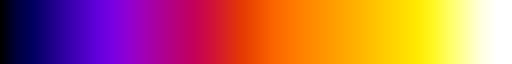

In [4]:
from psf_extractor.util import get_Daans_special_cmap
fire = get_Daans_special_cmap()
fire

In [5]:
import trackpy
from psf_extractor import load_stack, plot_mip

## 2) Create stack
---

In [6]:
# Set directory of image stack
file_pattern = '../data/sample_zstack_png_sequence/'
# Load image stack
stack = load_stack(file_pattern)

INFO:root:Creating stack from directory.


  0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:(32, 2048, 2448) image stack created succesfully.


## 3) Find features
---
The first step in the workflow is to detect features (e.g. fluorescent beads) within a 3D image stack. Features are found using `trackpy.locate`, which takes the image stack and expected feature diameters as input. No constraints are provided to `trackpy.locate` such that it returns all possible features on the scale of the expected feature dimensions. We then go through a series of filtering steps to end up with a feature set that ought to be single PSF localizations.

#### Maximum intensity projection in `z`

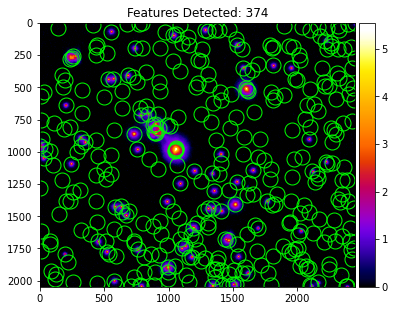

In [7]:
# Get MIP
mip = np.max(stack, axis=0)

# Locate features
df_features = trackpy.locate(mip, diameter=[dy, dx]).reset_index(drop=True)
N_features = len(df_features)

# Plot MIP
plot_mip(mip, features=df_features)

## 4) Mass-based filtering
---

The mass is the "integrated brightness" of a feature. It is important to choose reasonable lower and upper bounds to filter out spurious features (salt) smaller than the PSF and clusters larger than the PSF. It's difficult to know these bounds _a priori_, as the appropriate bounds will vary from dataset to dataset. So it is useful to sample a logarithmic range of candidate bounds and choose proper minimum and maximum masses based on visual inspection.

In [8]:
from ipywidgets import interact, fixed, FloatLogSlider
from psf_extractor import get_min_masses, get_max_masses, plot_mass_range_interactive

#### Choose minimum mass

In [9]:
# Choose minimum mass range
min_masses = get_min_masses(mip, dx=dx, n=35, b=20)

# Interactive plot
widget = interact(plot_mass_range_interactive,
                  mip=fixed(mip),
                  mass=FloatLogSlider(value=np.median(min_masses),
                                      min=np.log10(min_masses.min()),
                                      max=np.log10(min_masses.max())),
                  features=fixed(df_features),
                  filtering=fixed('min'));

interactive(children=(FloatLogSlider(value=2.4639943838277563, description='mass', max=1.6926697092718745, min…

In [10]:
# Set minimum mass
min_mass = widget.widget.children[0].value

# Filter out dim features
df_min = df_features.loc[df_features['raw_mass'] > min_mass]

#### Choose maximum mass

In [11]:
# Get candidate minimum masses
max_masses = get_max_masses(min_mass, b=20, n=31)

widget = interact(plot_mass_range_interactive,
                  mip=fixed(mip),
                  mass=FloatLogSlider(value=np.median(max_masses),
                                      min=np.log10(max_masses.min()),
                                      max=np.log10(max_masses.max())),
                  features=fixed(df_min),
                  filtering=fixed('max'));

interactive(children=(FloatLogSlider(value=11.019317876833144, description='mass', max=1.6926697092718745, min…

In [12]:
# Set minimum mass
max_mass = widget.widget.children[0].value
# Filter out super bright features
df_max = df_min.loc[df_min['raw_mass'] < max_mass]
# Update feature set
df_features = df_max.reset_index(drop=True)

# Output
out = f"""\
Minimum mass.................. {min_mass:.2f}
Maximum mass.................. {max_mass:.2f}
Detected features (initial)... {N_features:.0f}
Too dim (min filtered)........ {N_features-len(df_min):.0f}
Too bright (max filtered)..... {len(df_min)-len(df_max):.0f}
Remaining features............ {len(df_features):.0f}
Random sample of features.....
"""
print(out)
df_features.sample(5)

Minimum mass.................. 2.46
Maximum mass.................. 11.02
Detected features (initial)... 374
Too dim (min filtered)........ 305
Too bright (max filtered)..... 4
Remaining features............ 65
Random sample of features.....



,y,x,mass,size,ecc,signal,raw_mass,ep
7,329.983278,1809.972129,0.417519,1.379092,0.104226,0.042357,3.988236,0.004399
9,348.885976,1947.091743,0.355148,1.367570,0.143702,0.037702,3.372549,0.005217
13,517.925197,1604.881890,0.118227,1.221526,0.167525,0.016291,3.345098,0.005260
16,714.995475,781.851584,0.514336,1.362391,0.118175,0.055390,4.760784,0.003676
41,1424.070668,633.008712,0.480822,1.383067,0.103343,0.048408,4.650980,0.003764


## 5) Filter out overlapping features
---

Overlapping PSFs must be removed so that they do not distort the PSF characterization. To remove them, a virtual bounding box is created around each feature and checked for overlap against every other feature's bounding box.

In [13]:
from psf_extractor import remove_overlapping_features, plot_overlapping_features

In [14]:
# Set dimensions of bounding box based on expected feature diameter
wx = 10*dx_nm/psx  # px
wy = 10*dy_nm/psy  # px

# Remove overlapping features
N_features = len(df_features)
df, overlapping = remove_overlapping_features(df_features, wx=wx, wy=wy, return_indices=True)

  0%|          | 0/2080 [00:00<?, ?it/s]

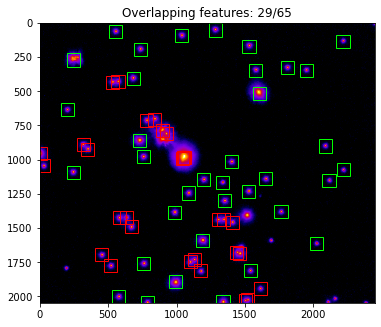

In [15]:
plot_overlapping_features(mip, df_features, overlapping, width=wx)

In [16]:
# Update feature set
df_features = df.reset_index(drop=True)

# Output
out = f"""\
Initial features............ {N_features:.0f}
Overlapping features........ {overlapping.size:.0f}
Remaining features.......... {len(df_features):.0f}
Random sample of features...
"""
print(out)
df_features.sample(5)

Initial features............ 65
Overlapping features........ 29
Remaining features.......... 36
Random sample of features...



,y,x,mass,size,ecc,signal,raw_mass,ep
22,1166.928177,1336.925414,0.336995,1.366530,0.108925,0.036772,3.192157,0.005517
15,979.868093,757.929590,0.522248,1.380731,0.128728,0.052132,5.043138,0.003468
14,900.954491,2085.924551,0.388661,1.352310,0.088004,0.044219,3.549020,0.004953
27,1384.871212,986.776515,0.491528,1.368615,0.087837,0.051666,4.772549,0.003667
35,2042.013685,787.052786,0.476168,1.388403,0.085525,0.046081,4.439216,0.003946


## 6) Extract PSFs
---

All of the filtered PSFs must be extracted before they can be aligned and averaged. We already have the rough coordinates of each PSF from filtering the features detected by `trackpy.locate`. So we simply define a subvolume containing the PSF and extract.

In [17]:
from psf_extractor import extract_psfs, plot_psfs

#### Define subvolume and extract PSFs

In [18]:
# Set dimensions of PSF subvolume based on expected feature diameter
wx = 5 * dx_nm/psx  # px
wy = 5 * dy_nm/psy  # px
wz = 3 * wx         # px
shape_psf = (wz, wy, wx)

# Extract PSFs
N_features = len(df_features)
psfs, df = extract_psfs(stack, features=df_features, shape=shape_psf, return_features=True)

#### Plot the maximum intensity projection of each extracted PSF

  0%|          | 0/34 [00:00<?, ?it/s]

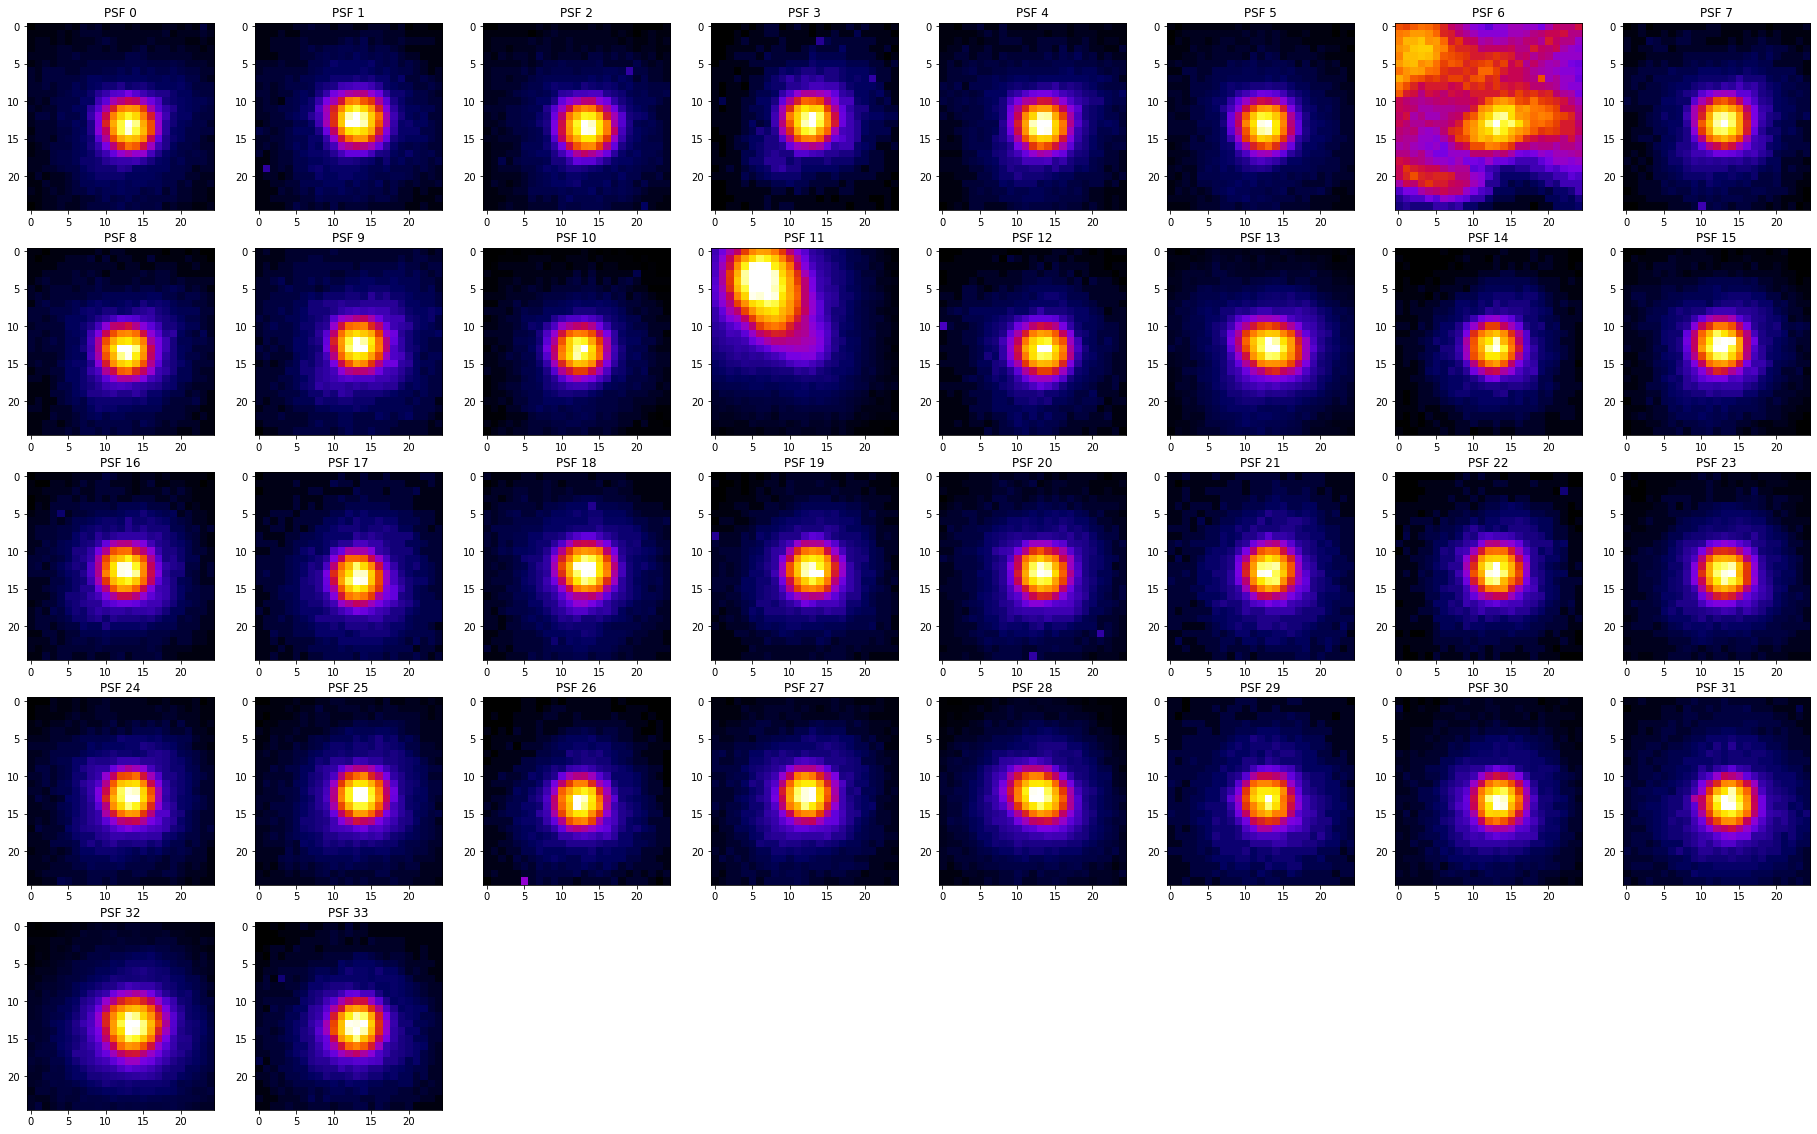

In [19]:
# Plot PSF MIPs
plot_psfs(psfs)

In [20]:
# Update feature set
df_features = df.reset_index(drop=True)

# Output
out = f"""\
Initial features............ {N_features:.0f}
Edge features............... {N_features - len(psfs):.0f}
Remaining features.......... {len(df_features):.0f}
Random sample of features...
"""
print(out)
df_features.sample(5)

Initial features............ 36
Edge features............... 2
Remaining features.......... 34
Random sample of features...



,y,x,mass,size,ecc,signal,raw_mass,ep
0,53.087674,1282.010417,0.536212,1.366451,0.103031,0.057252,4.980392,0.003512
22,1166.928177,1336.925414,0.336995,1.366530,0.108925,0.036772,3.192157,0.005517
24,1244.915641,1088.086116,0.529696,1.375789,0.138135,0.053994,4.890196,0.003578
9,348.885976,1947.091743,0.355148,1.367570,0.143702,0.037702,3.372549,0.005217
2,95.122066,1037.132394,0.495717,1.376871,0.123919,0.051201,4.752941,0.003682


## 7) Filter out strange PSFs
---

Use the Pearson correlation coefficient to filter out oultier PSFs. Each PSF is compared to every other PSF. Outlier criteria is based on a PSF having a PCC that frequently falls outside the acceptable range ($\mu_{PCC} \,\pm\, 3\sigma_{PCC}$).

Why isn't once enough? Because it takes 2 PSFs to generate a wild PCC value. One of these PSFs may be totally fine, but the only way to tell a typical PSF from an outlier is by checking the number of occurences each PSF falls in the outlier range.

How many times is frequently? A bit arbitrary, but 3× the average number of occurences seems to work empirically.

In [21]:
from psf_extractor import detect_outlier_psfs, plot_pcc_distribution

In [22]:
# Set minimum PCC threshold
pcc_min = 0.9

# Detect outlier PCCs
outliers, pccs = detect_outlier_psfs(psfs, pcc_min=pcc_min, return_pccs=True)

  0%|          | 0/561 [00:00<?, ?it/s]

#### Plot distribution of Pearson correlation coefficients

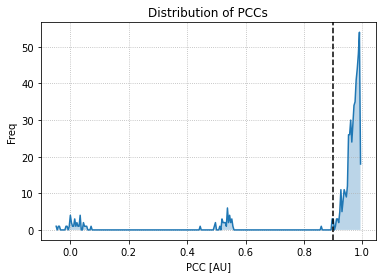

In [23]:
plot_pcc_distribution(pccs, pcc_min=pcc_min, bins=pccs.size//2)

In [24]:
# Update feature set
df_features = df_features.drop(index=outliers).reset_index(drop=True)

# Output
out = f"""\
Initial features............ {len(psfs):.0f}
Outlier features............ {outliers.size:.0f}
Remaining features.......... {len(df_features):.0f}
Random sample of features...
"""
print(out)
df_features.sample(5)

Initial features............ 34
Outlier features............ 2
Remaining features.......... 32
Random sample of features...



,y,x,mass,size,ecc,signal,raw_mass,ep
3,136.886115,2216.925117,0.298361,1.359659,0.109146,0.031186,2.780392,0.006352
16,1091.867810,244.073663,0.461273,1.381732,0.104143,0.045615,4.600000,0.003806
12,900.954491,2085.924551,0.388661,1.352310,0.088004,0.044219,3.549020,0.004953
29,1810.125794,1538.168996,0.366319,1.366694,0.092636,0.039099,3.521569,0.004992
4,170.094812,1530.083184,0.520387,1.363005,0.122515,0.056321,4.800000,0.003646


## 8) Localize PSFs
---

The individual PSF positions must be localized with subpixel accuracy in $x$, $y$, and $z$. First, we fit a 2D Gaussian to each PSF in the maximum intensity projection to get the $x$, $y$ position. Then we fit a 1D Gaussian to the line profile through the center of the PSF to get the $z$ position.

* 2D Gaussian fit for $x$, $y$ localization 
* 1D Gaussian fit for $z$ localization
  * Might it be better to sum/integrate in x, y?

In [25]:
from psf_extractor import localize_psfs, plot_psf_localizations

In [26]:
# Re-extract PSFs based on updated feature set
psfs = extract_psfs(stack, features=df_features, shape=shape_psf)

# Localize PSFs
df_locations = localize_psfs(psfs)
df_locations.head()

#### Plot localization data

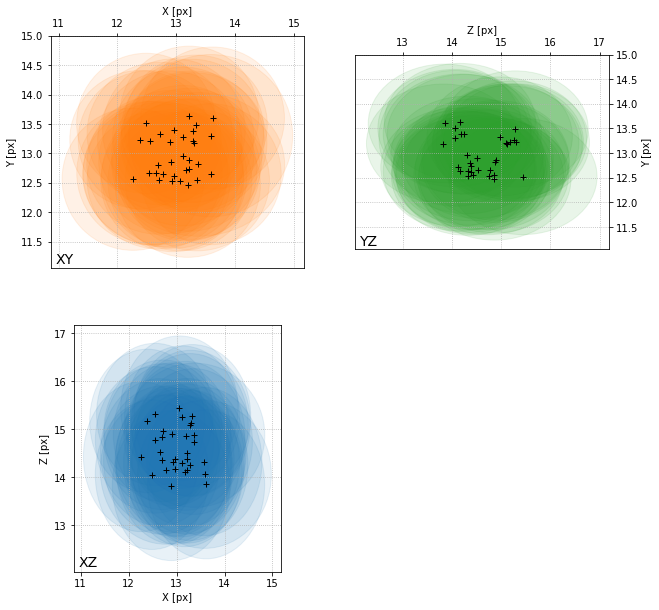

In [28]:
plot_psf_localizations(df_locations)

## 9) Characterize PSF
---

Upsample and align PSFs

#### Upsample and align PSFs

In [29]:
from psf_extractor import align_psfs, plot_psf

In [30]:
# Set upsample factor
usf = 5

# Align PSFs
psf_sum = align_psfs(psfs, df_locations, upsample_factor=usf)

  0%|          | 0/32 [00:00<?, ?it/s]

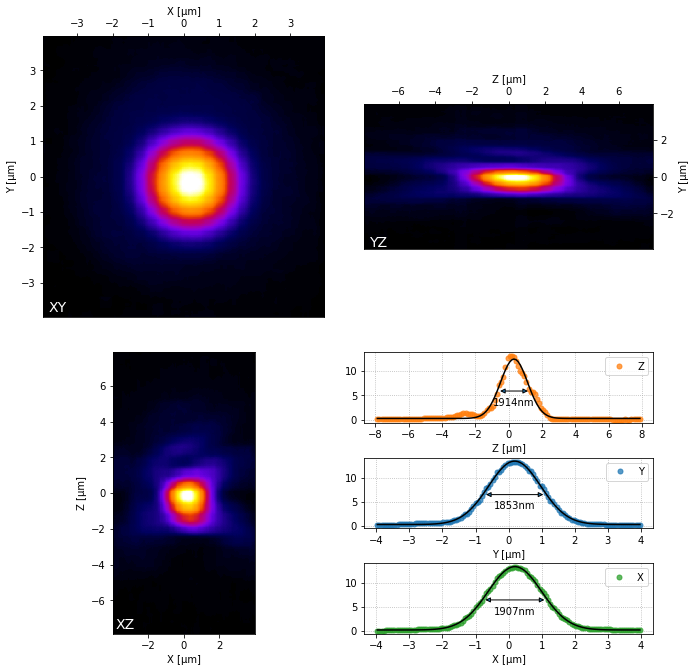

In [31]:
plot_psf(psf_sum, psx, psy, psz, crop=True)